<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/downloadDicomAndConvertNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook does the first step in the split workflow on Terra**
DICOM files are downloaded from IDC and converted to NIFTI files with dcm2niix or plastimatch. Whenever there are multiple NIFTI files for a series, such series are prohibited from continuing to Inference. A CSV file is created with a list of such series.

Please cite:

Li X, Morgan PS, Ashburner J, Smith J, Rorden C. (2016) The first step for neuroimaging data analysis: DICOM to NIfTI conversion. J Neurosci Methods. 264:47-56.

Shackleford, James A., Nagarajan Kandasamy and Gregory C. Sharp. “Plastimatch—An Open-Source Software for Radiotherapy Imaging.” (2014).



###**Installing Packages**

In [1]:
%%capture
#Installing dcm2niix and pigz
!apt-get install dcm2niix pigz lz4

In [2]:
%%capture
#Installing plastimatch
!apt-get install plastimatch 

In [3]:
%%capture
#install s5cmd
!wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
!tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
!rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
!mv s5cmd /usr/local/bin/s5cmd

###**Importing Packages**

In [4]:
import os
import sys
import time
import pandas as pd
from pathlib import Path
import shutil
import glob
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import matplotlib.pyplot as plt
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Tue Apr 18 16:24:28 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###**Parameters for papermill**

In [5]:
converterType='dcm2niix'
csvFilePath=''

###**For local testing**

In [8]:
!wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
csvFilePath = glob.glob('*.csv')[0]


--2023-04-18 16:24:39--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139861 (137K) [text/plain]
Saving to: ‘batch_1.csv’

batch_1.csv         100%[===================>] 136.58K  --.-KB/s    in 0.02s   

2023-04-18 16:24:39 (5.39 MB/s) - ‘batch_1.csv’ saved [139861/139861]



###**Reading CSV File containing s5cmd Urls**

In [9]:
start_time = time.time()
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')

read in 0.016416072845458984  seconds


In [10]:
SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()

###**Defining Functions**

In [11]:
#Creating Directories
try:
  shutil.rmtree(converterType)
except OSError:
  pass
os.mkdir(converterType)


In [12]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.

  """
  try:
    shutil.rmtree(f'idc_data/{series_id}')
  except OSError:
    pass
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [13]:
def convert_dicom_to_nifti(series_id):
  if converterType.lower()=='dcm2niix':
    try:
      shutil.rmtree(f'dcm2niix/{series_id}')
    except OSError:
      pass
    os.mkdir(f'dcm2niix/{series_id}')

    !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  else:
    try:
      shutil.rmtree(f'plastimatch/{series_id}')
    except OSError:
      pass
    os.mkdir(f'plastimatch/{series_id}')
    """
    Make sure to check the s5cmd urls for the destination directory and 
    plastimatch input directory must be changed accordingly
    dcm2niix, however, checks upto depth 5 to find DICOM files

    """
    !plastimatch convert --input /{curr_dir}/idc_data/{series_id} --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz


  try:
      shutil.rmtree('idc_data')
  except OSError:
      pass
  os.mkdir('idc_data')

In [14]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb,  disk_usage_all, disk_total

In [15]:
def download_and_process_series(series_id):
    log = pd.DataFrame({'SeriesInstanceUID': [series_id]})

    start_time = time.time()
    download_dicom_data( series_id)
    download_time = time.time() - start_time

    log['download_time'] = download_time

    start_time = time.time()
    convert_dicom_to_nifti(series_id)
    convert_dicom_to_nifti_time = time.time() - start_time

    log['NiftiConverter_time'] = convert_dicom_to_nifti_time

    global runtime_stats
    runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)



###**Downloading and Converting**

Copying files from IDC buckets..
Done in 0.622821 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 181 DICOM file(s)
Convert 181 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.11872245252939435071116658934_1_OPA_GE_LSPR16_STANDARD_330_2.5_120_80_58.2_1.4_20000102000000_2 (512x512x181x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.11872245252939435071116658934_1_OPA_GE_LSPR16_STANDARD_330_2.5_120_80_58.2_1.4_20000102000000_2.nii"
Conversion required 6.255639 seconds (0.366965 for core code).


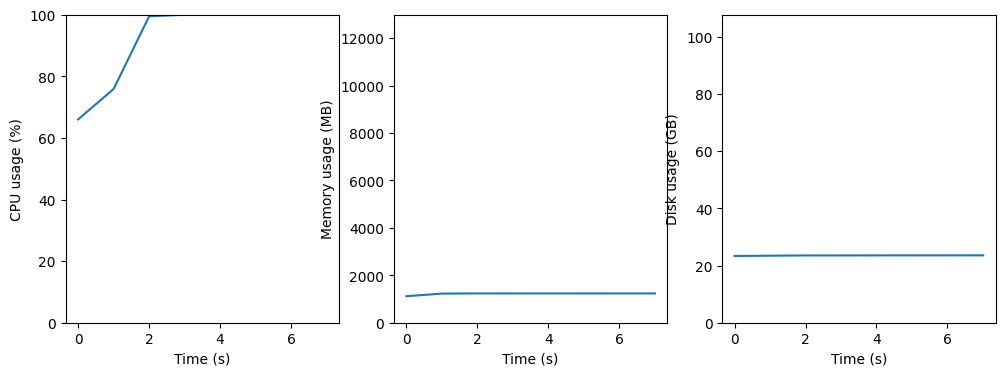

Copying files from IDC buckets..
Done in 0.521746 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 115 DICOM file(s)
Convert 115 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2 (512x512x115x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2.nii"
Conversion required 5.236592 seconds (0.210617 for core code).


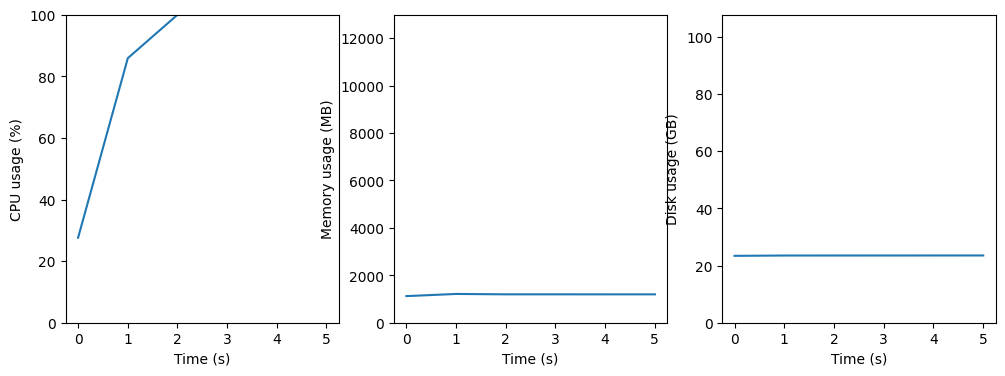

Copying files from IDC buckets..
Done in 0.519958 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 135 DICOM file(s)
Convert 135 DICOM as //content/dcm2niix/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243_0_OPA_GE_LSQX_STANDARD_360_2.5_120_na_na_na_19990102000000_2 (512x512x135x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243_0_OPA_GE_LSQX_STANDARD_360_2.5_120_na_na_na_19990102000000_2.nii"
Conversion required 3.888236 seconds (0.251145 for core code).


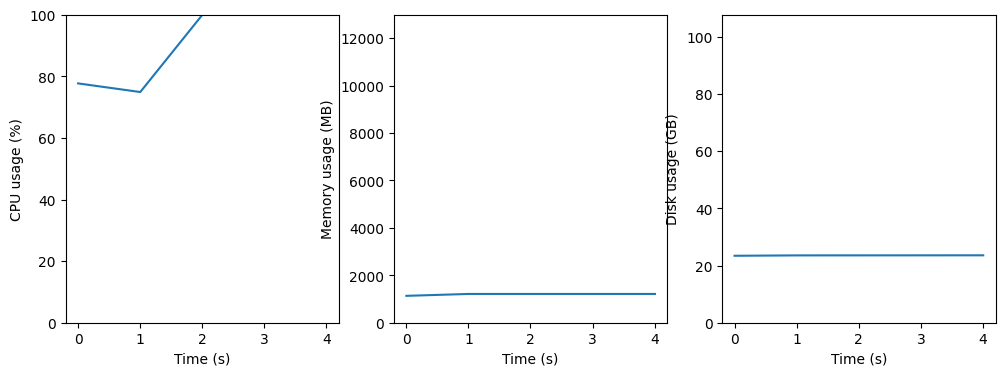

Copying files from IDC buckets..
Done in 0.820563 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 191 DICOM file(s)
Convert 191 DICOM as //content/dcm2niix/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696_0_OPA_GE_LSQX_STANDARD_352_2.5_120_64_0.1_1.5_19990102000000_2 (512x512x191x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696_0_OPA_GE_LSQX_STANDARD_352_2.5_120_64_0.1_1.5_19990102000000_2.nii"
Conversion required 7.032374 seconds (0.352415 for core code).


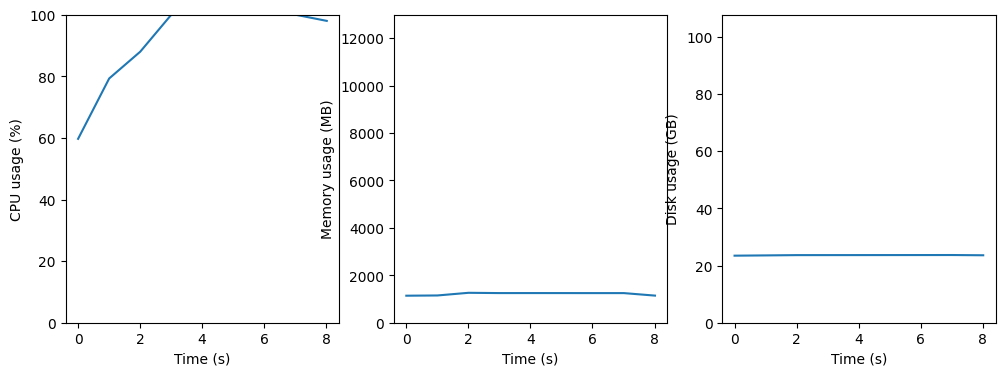

Copying files from IDC buckets..
Done in 0.622624 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 128 DICOM file(s)
Convert 128 DICOM as //content/dcm2niix/1.2.840.113654.2.55.142419057730651121165090739113900499978/1.2.840.113654.2.55.142419057730651121165090739113900499978_2_OPA_GE_LSQX_BONE_360_2.5_120_72_0.1_1.5_20010102000000_3 (512x512x128x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.142419057730651121165090739113900499978/1.2.840.113654.2.55.142419057730651121165090739113900499978_2_OPA_GE_LSQX_BONE_360_2.5_120_72_0.1_1.5_20010102000000_3.nii"
Conversion required 3.556607 seconds (0.236975 for core code).


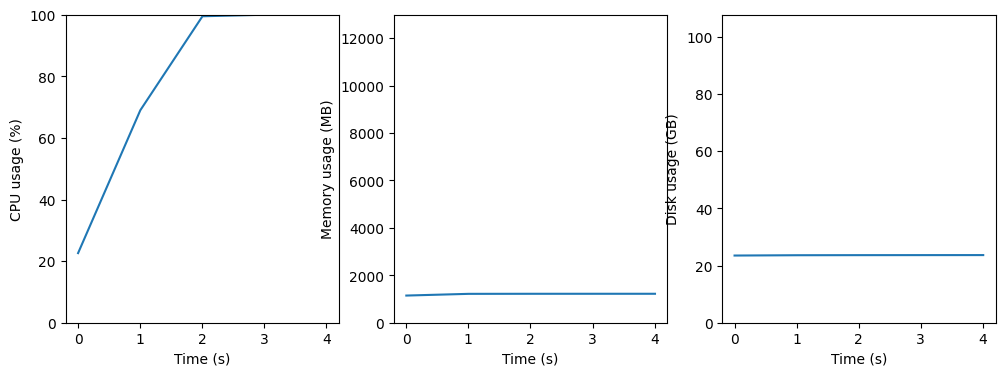

Copying files from IDC buckets..
Done in 0.626405 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 122 DICOM file(s)
Convert 122 DICOM as //content/dcm2niix/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706_0_OPA_GE_LSQX_STANDARD_350_2.5_120_na_na_na_19990102000000_2 (512x512x122x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706_0_OPA_GE_LSQX_STANDARD_350_2.5_120_na_na_na_19990102000000_2.nii"
Conversion required 4.526357 seconds (0.258052 for core code).


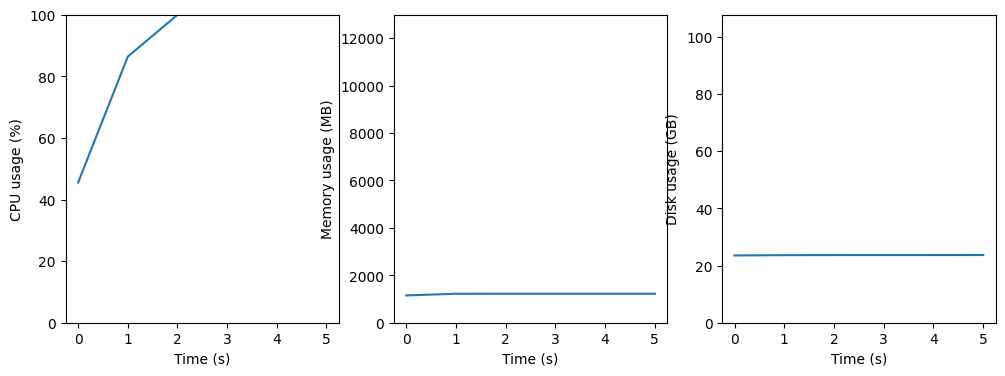

Copying files from IDC buckets..
Done in 0.624464 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 139 DICOM file(s)
Convert 139 DICOM as //content/dcm2niix/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397_1_OPA_GE_LSQX_STANDARD_360_2.5_140_40_0_1.5_20000102000000_2 (512x512x139x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397_1_OPA_GE_LSQX_STANDARD_360_2.5_140_40_0_1.5_20000102000000_2.nii"
Conversion required 4.197984 seconds (0.253758 for core code).


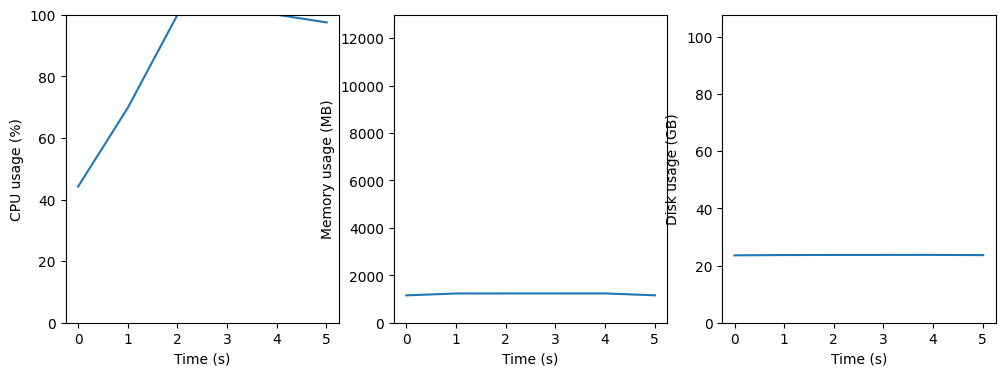

Copying files from IDC buckets..
Done in 0.622454 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 112 DICOM file(s)
Convert 112 DICOM as //content/dcm2niix/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510_0_OPA_GE_LSQX_STANDARD_310_2.5_120_64_0.1_1.5_19990102000000_2 (512x512x112x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510_0_OPA_GE_LSQX_STANDARD_310_2.5_120_64_0.1_1.5_19990102000000_2.nii"
Conversion required 5.111221 seconds (0.253575 for core code).


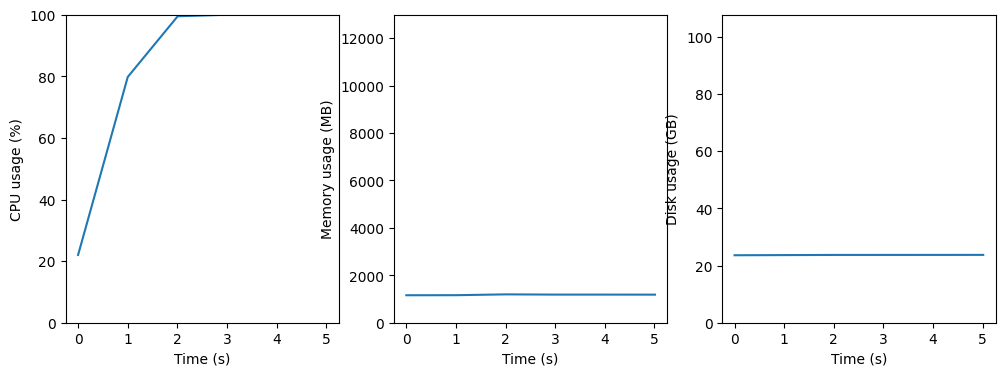

Copying files from IDC buckets..
Done in 0.523157 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 158 DICOM file(s)
Convert 158 DICOM as //content/dcm2niix/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332_1_OPA_GE_LSQX_STANDARD_360_2.5_120_48_0_1.5_20000102000000_2 (512x512x158x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332_1_OPA_GE_LSQX_STANDARD_360_2.5_120_48_0_1.5_20000102000000_2.nii"
Conversion required 4.528913 seconds (0.330428 for core code).


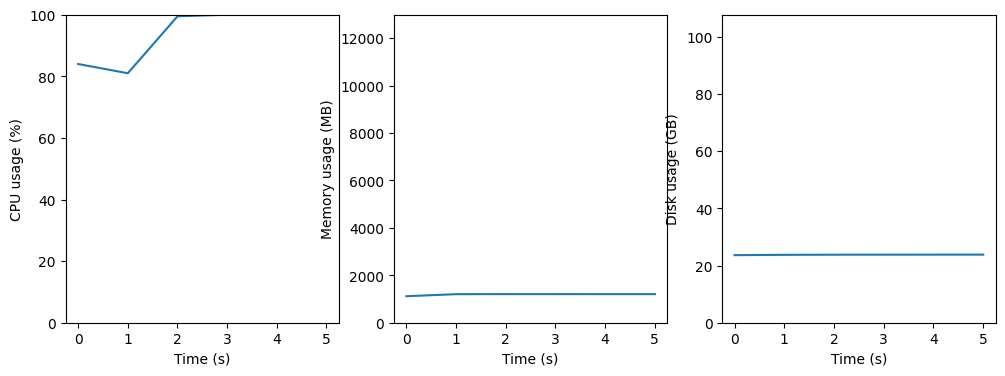

Copying files from IDC buckets..
Done in 0.627716 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 130 DICOM file(s)
Convert 130 DICOM as //content/dcm2niix/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482_0_OPA_GE_HSQX_BONE_340_2.5_120_56_0.1_1.5_19990102000000_3 (512x512x130x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482_0_OPA_GE_HSQX_BONE_340_2.5_120_56_0.1_1.5_19990102000000_3.nii"
Conversion required 5.185668 seconds (0.251798 for core code).


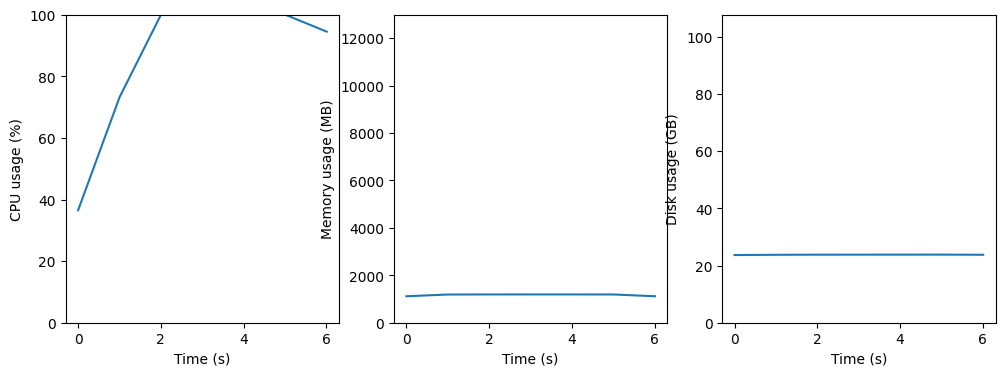

Copying files from IDC buckets..
Done in 0.628309 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 128 DICOM file(s)
Convert 128 DICOM as //content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2 (512x512x128x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2.nii"
Conversion required 3.568104 seconds (0.243330 for core code).


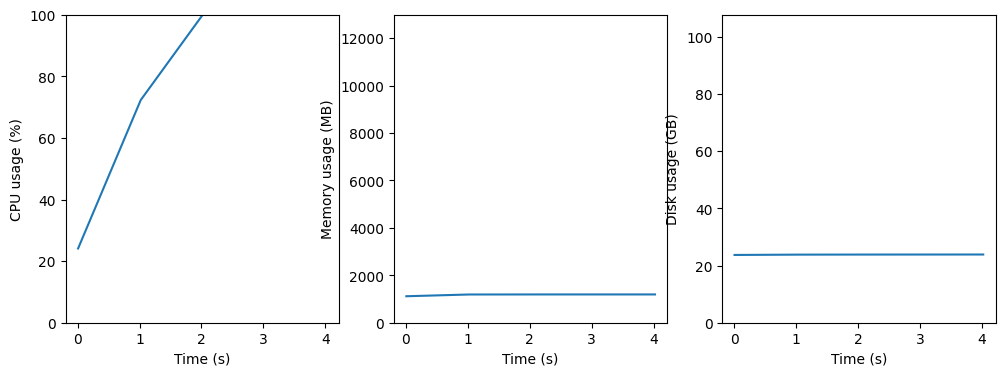

Copying files from IDC buckets..
Done in 0.930332 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 180 DICOM file(s)
Convert 180 DICOM as //content/dcm2niix/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215_1_OPA_GE_LSQX_STANDARD_360_2.5_120_64_0.1_1.5_20000102000000_2 (512x512x180x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215_1_OPA_GE_LSQX_STANDARD_360_2.5_120_64_0.1_1.5_20000102000000_2.nii"
Conversion required 6.475957 seconds (0.332813 for core code).


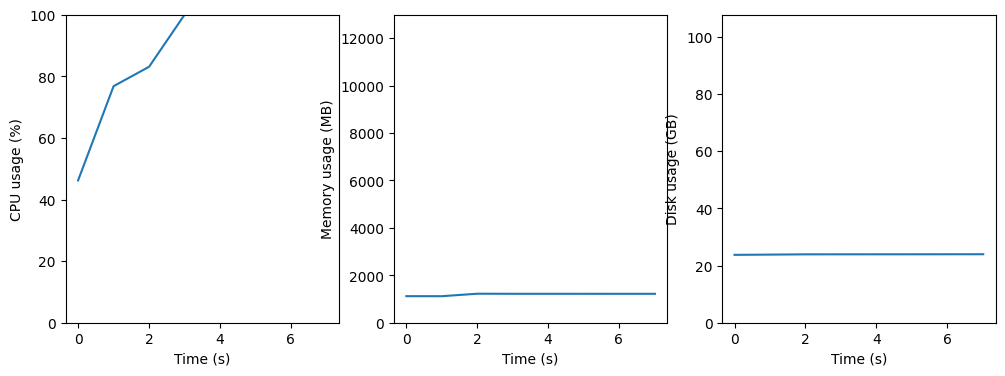

In [16]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','download_time',
                                      'NiftiConverter_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 'disk_usage_all', 'disk_total'
                                      ])

if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(download_and_process_series, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total    

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###**Monitoring for dcm2niix Errors**

In [17]:
import os
import csv

def check_dcm2niix_errors(path):
    for series_id in os.listdir(path):
        series_id_path = os.path.join(path, series_id)
        if os.path.isdir(series_id_path):
            num_files = len([f for f in os.listdir(series_id_path) if os.path.isfile(os.path.join(series_id_path, f))])
            if num_files > 1:
                print(f'Found one more than one nifti for the {series_id}')
                with open('dcm2niix_errors.csv', 'a') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow([series_id])
                shutil.rmtree(f'dcm2niix/{series_id}')


In [18]:
if converterType.lower()=='dcm2niix':
    check_dcm2niix_errors(f'/{curr_dir}/dcm2niix')

###**Compressing Output Files**


In [21]:
try:
  os.remove('downloadDicomAndConvertNiftiFiles.tar.lz4')
except OSError:
  pass
start_time = time.time()
!tar cvf - -C {curr_dir} {converterType} | lz4 > downloadDicomAndConvertNiftiFiles.tar.lz4
archiving_time = time.time() - start_time


dcm2niix/
dcm2niix/1.2.840.113654.2.55.243990451406006403331425809632881193215/
dcm2niix/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215_1_OPA_GE_LSQX_STANDARD_360_2.5_120_64_0.1_1.5_20000102000000_2.nii.gz
dcm2niix/1.2.840.113654.2.55.146601594654322994982630019583270053397/
dcm2niix/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397_1_OPA_GE_LSQX_STANDARD_360_2.5_140_40_0_1.5_20000102000000_2.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.11872245252939435071116658934_1_OPA_GE_LSPR16_STANDARD_330_2.5_120_80_58.2_1.4_20000102000000_2.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5

###Utilization Metrics

In [20]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['csv_read_time']=read_time
runtime_stats['archiving_time']=archiving_time

try:
  os.remove('downloadDicomAndConvertUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv downloadDicomAndConvertUsageMetrics.lz4
runtime_stats

Compressed 5085 bytes into 3220 bytes ==> 63.32%


,SeriesInstanceUID,download_time,NiftiConverter_time,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total,csv_read_time,archiving_time
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529...,0.753602,6.378470,"[[[66.0, 75.9, 99.5, 100.0, 100.0, 100.0, 100....","[[[1117.19140625, 1227.59765625, 1235.2421875,...",[12985.5390625],"[[[23.34793472290039, 23.437042236328125, 23.5...",107.715084,0.016416,1.554871
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401...,0.549510,5.276177,"[[[27.6, 85.9, 100.0, 100.0, 100.0, 100.0]]]","[[[1121.84765625, 1213.125, 1196.703125, 1196....",[12985.5390625],"[[[23.388256072998047, 23.501541137695312, 23....",107.715084,0.016416,1.554871
2,1.2.840.113654.2.55.10087518978221069034420730...,0.647338,3.958123,"[[[77.7, 74.9, 100.0, 100.0, 100.0]]]","[[[1133.328125, 1212.9609375, 1213.0, 1213.144...",[12985.5390625],"[[[23.41504669189453, 23.547466278076172, 23.5...",107.715084,0.016416,1.554871
3,1.2.840.113654.2.55.11304038617854784357127123...,0.940775,7.098707,"[[[59.7, 79.3, 88.0, 100.0, 100.0, 100.0, 100....","[[[1139.1953125, 1149.19921875, 1261.37109375,...",[12985.5390625],"[[[23.449085235595703, 23.543102264404297, 23....",107.715084,0.016416,1.554871
4,1.2.840.113654.2.55.14241905773065112116509073...,0.744970,3.617335,"[[[22.6, 69.0, 99.5, 100.0, 100.0]]]","[[[1145.1640625, 1217.36328125, 1219.96875, 12...",[12985.5390625],"[[[23.495494842529297, 23.604618072509766, 23....",107.715084,0.016416,1.554871
5,1.2.840.113654.2.55.14382674871619950799472325...,0.745200,4.601916,"[[[45.5, 86.4, 100.0, 100.0, 100.0, 100.0]]]","[[[1150.484375, 1220.41015625, 1223.1015625, 1...",[12985.5390625],"[[[23.530906677246094, 23.621097564697266, 23....",107.715084,0.016416,1.554871
6,1.2.840.113654.2.55.14660159465432299498263001...,0.751185,4.265746,"[[[44.2, 69.8, 100.0, 100.0, 100.0, 97.5]]]","[[[1153.33203125, 1232.08203125, 1234.27734375...",[12985.5390625],"[[[23.562366485595703, 23.667278289794922, 23....",107.715084,0.016416,1.554871
7,1.2.840.113654.2.55.15480970559124215907525360...,0.748934,5.242166,"[[[22.0, 79.8, 99.5, 100.0, 100.0, 100.0]]]","[[[1158.3828125, 1160.84765625, 1195.16796875,...",[12985.5390625],"[[[23.596027374267578, 23.651153564453125, 23....",107.715084,0.016416,1.554871
8,1.2.840.113654.2.55.18530918259180563451786039...,0.650335,4.665271,"[[[84.0, 81.0, 99.5, 100.0, 100.0, 100.0]]]","[[[1117.2265625, 1203.69921875, 1205.9140625, ...",[12985.5390625],"[[[23.624435424804688, 23.744911193847656, 23....",107.715084,0.016416,1.554871
9,1.2.840.113654.2.55.21661400233888873398735052...,0.755432,5.286575,"[[[36.5, 73.2, 100.0, 100.0, 100.0, 100.0, 94....","[[[1115.6875, 1188.91015625, 1192.25390625, 11...",[12985.5390625],"[[[23.66510772705078, 23.757343292236328, 23.7...",107.715084,0.016416,1.554871
